In [9]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import gaussian_kde
from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture
from sklearn.metrics import silhouette_score
from sklearn.metrics import pairwise_distances
from scipy.spatial.distance import cdist, cosine
from scipy.ndimage import convolve1d
from sklearn.cluster import DBSCAN
from sklearn.cluster import OPTICS
from sklearn.cluster import SpectralClustering
import matplotlib.pyplot as plt
from sklearn.preprocessing import normalize
import tensorflow as tf
from joblib import Parallel, delayed

from matplotlib import cm
import matplotlib.cbook as cbook
import matplotlib.colors as colors

import pandas as pd
import xarray as xr
from netCDF4 import Dataset, num2date, date2num
from datetime import datetime, timedelta
import os

import seaborn as sns
import cmocean as cmocn

%matplotlib inline

2025-04-29 16:40:38.125444: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-04-29 16:40:38.152234: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:10575] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-04-29 16:40:38.152262: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:479] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-04-29 16:40:38.153281: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1442] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-04-29 16:40:38.158094: I tensorflow/core/platform/cpu_feature_gua

In [2]:
ds = xr.open_dataset('rainFlagRemovedBuoyDataBadQualityRemovedMatchup.nc')
df = ds.to_dataframe()
df_orig = df.copy()

In [3]:
list(df.keys())

['Wind Direction (TAO)',
 'WDIR_QC',
 'WDIR_DM',
 'Wind Speed (TAO)',
 'WSPD_QC',
 'WSPD_DM',
 'Zonal Wind Speed (TAO)',
 'Meridional Wind Speed (TAO)',
 'Sea Surface Temperature (TAO)',
 'SST_QC',
 'SST_DM',
 'Relative Humidity (TAO)',
 'RELH_QC',
 'RELH_DM',
 'Air Temperature (TAO)',
 'AIRT_QC',
 'AIRT_DM',
 'Neutral Wind Speed at 10m (TAO)',
 'Wind Speed at 10m (TAO)',
 'mean_WSPD',
 'std_WSPD',
 'mean_WSPD_10N',
 'std_WSPD_10N',
 'mean_SST',
 'std_SST',
 'mean_AIRT',
 'std_AIRT',
 'mean_RELH',
 'std_RELH',
 'mean_SST - AIRT',
 'std_SST - AIRT',
 'mean_cosWDIR',
 'std_cosWDIR',
 'mean_sinWDIR',
 'std_sinWDIR',
 'LATITUDE',
 'LONGITUDE',
 'TAO_TIME',
 'Deployment index',
 'Wind Speed (ASCAT)',
 'Wind Direction (ASCAT)',
 'wvc_quality_flag',
 'model_speed',
 'model_dir',
 'bs_distance',
 'dist_from_TAO_pos',
 'AS_TIME',
 'Speed Difference (ASCAT - TAO)',
 'Zonal Neutral Wind Speed (TAO)',
 'Meridional Neutral Wind Speed (TAO)',
 'Zonal Wind Speed (ASCAT)',
 'Meridional Wind Speed (ASC

/home/shikhar.rai/anaconda3/envs/mpiNetCDF/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/shikhar.rai/anaconda3/envs/mpiNetCDF/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/home/shikhar.rai/anaconda3/envs/mpiNetCDF/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/shikhar.rai/anaconda3/envs/mpiNetCDF/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option i

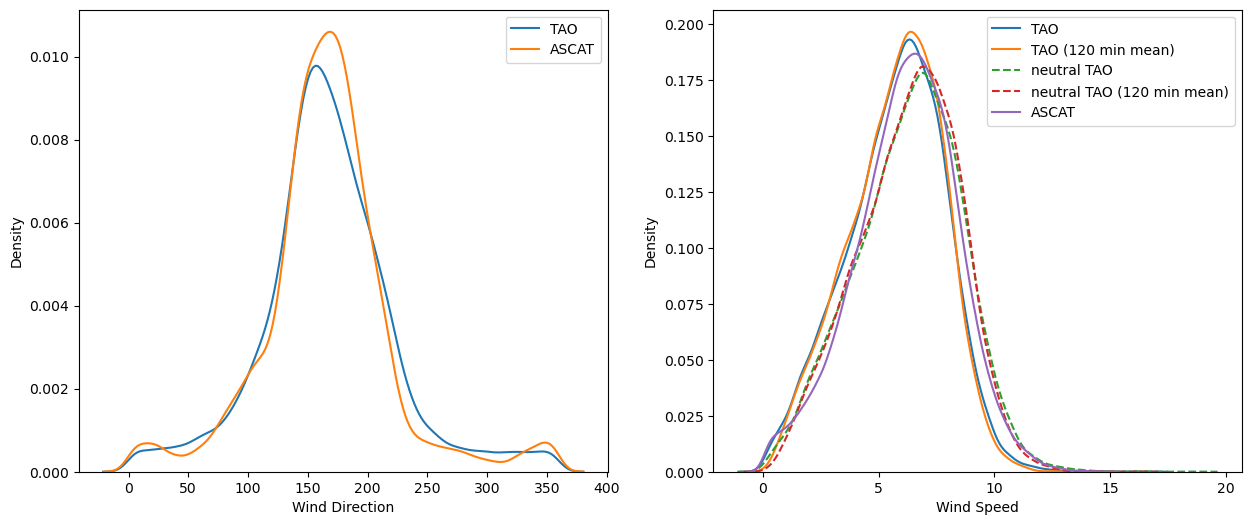

In [4]:
fig, axes = plt.subplots(ncols=2, figsize=(15,6))

ax = axes[0]
sns.kdeplot(df['Wind Direction (TAO)'], ax = ax, label = 'TAO')
#sns.kdeplot(df['mean WDIR 30min'], ax = ax, label = 'TAO (30 min mean)')
#sns.kdeplot(df['mean WDIR 60min'], ax = ax, label = 'TAO (1 hr mean)')
#sns.kdeplot(df['mean WDIR 120min'], ax = ax, label = 'TAO (2 hr mean)')
sns.kdeplot(df['Wind Direction (ASCAT)'], ax = ax, label = 'ASCAT')
ax.set_xlabel('Wind Direction')
ax.legend()

ax = axes[1]
sns.kdeplot(df['Wind Speed (TAO)'], ax = ax, label = 'TAO')
sns.kdeplot(df['mean_WSPD'], ax = ax, label = 'TAO (120 min mean)')

sns.kdeplot(df['Neutral Wind Speed at 10m (TAO)'], linestyle="--", ax = ax, label = 'neutral TAO')
sns.kdeplot(df['mean_WSPD_10N'], linestyle="--", ax = ax, label = 'neutral TAO (120 min mean)')

sns.kdeplot(df['Wind Speed (ASCAT)'], ax = ax, label = 'ASCAT')
ax.set_xlabel('Wind Speed')
ax.legend()

0.9165643028448787

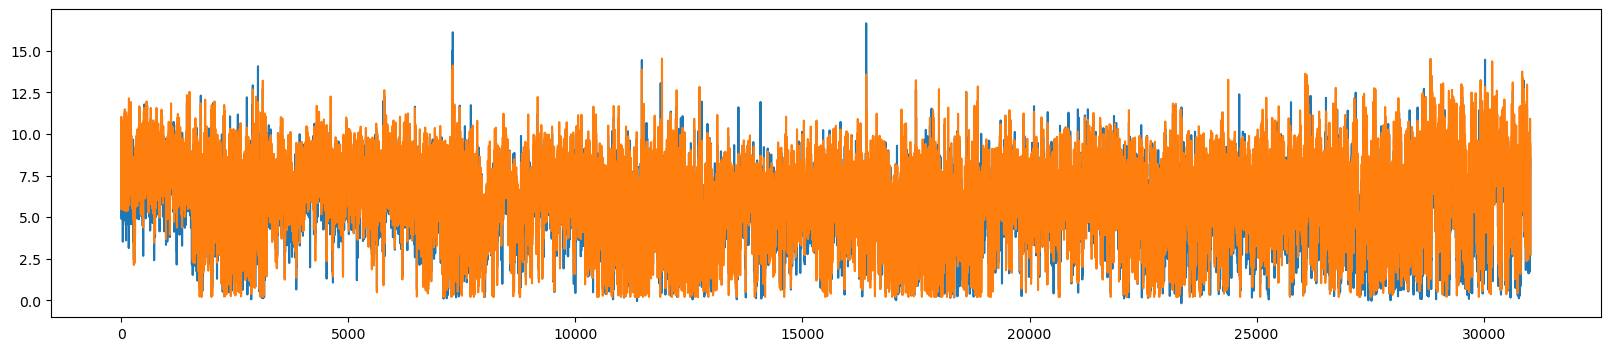

In [5]:
plt.figure(figsize=(20,4))
plt.plot(df['Wind Speed (TAO)'])
plt.plot(df['Wind Speed (ASCAT)'])
np.corrcoef(df['Wind Speed (TAO)'], df['Wind Speed (ASCAT)'])[0,1]

0.6949097130298022

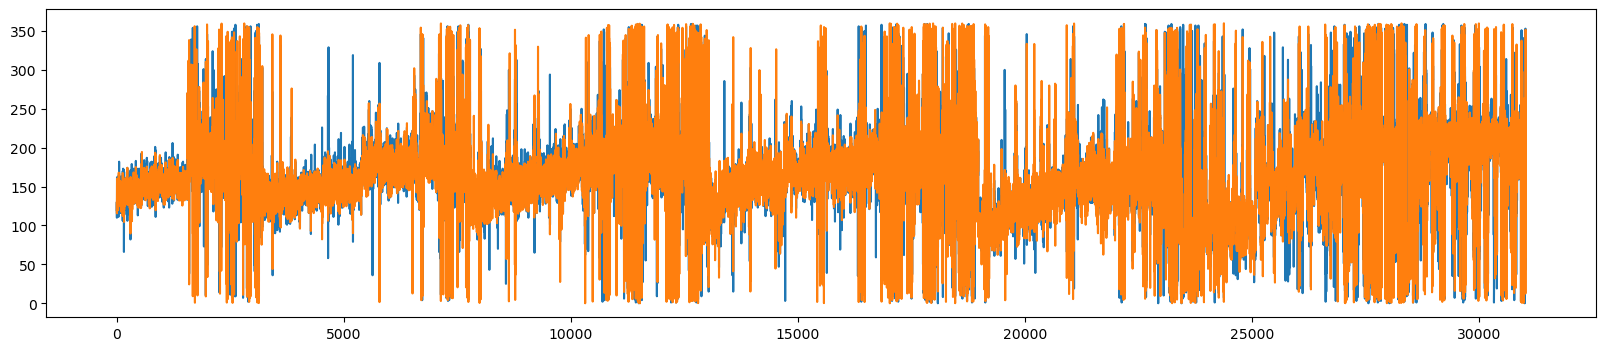

In [6]:
plt.figure(figsize=(20,4))
plt.plot(df['Wind Direction (TAO)'])
plt.plot(df['Wind Direction (ASCAT)'])
np.corrcoef(df['Wind Direction (TAO)'], df['Wind Direction (ASCAT)'])[0,1]

/home/shikhar.rai/anaconda3/envs/mpiNetCDF/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/shikhar.rai/anaconda3/envs/mpiNetCDF/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/shikhar.rai/anaconda3/envs/mpiNetCDF/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/shikhar.rai/anaconda3/envs/mpiNetCDF/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecat

Text(0.1, 0.95, 'B')

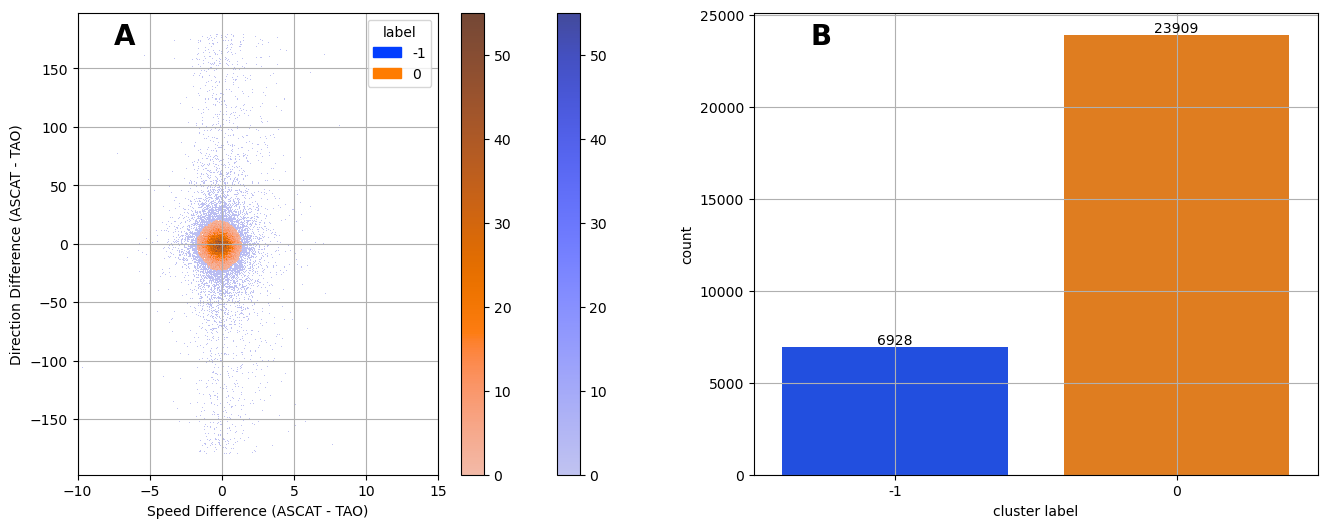

In [13]:
selectX = ['Speed Difference (ASCAT - TAO)',
          'cos(Direction Difference (ASCAT - TAO))',
          'sin(Direction Difference (ASCAT - TAO))']


X = df[selectX]

normX = (X - X.mean(axis=0))/ X.std(axis=0)

# kmeans = KMeans(n_clusters=9, random_state=0, n_init="auto", max_iter = 10000).fit(normX)
# df['label'] = kmeans.labels_

dbscan = DBSCAN(eps=0.30, min_samples= 500)
df['label'] = dbscan.fit_predict(normX)

# optics = OPTICS(min_samples=50 ) #cluster_method='dbscan', eps=0.25)
# df['label'] = optics.fit_predict(normX)

fig,  axes = plt.subplots(ncols = 2, figsize=(16,6))

ax = axes[0]
# ax.remove()  # Remove the existing second subplot
# ax = fig.add_subplot(121, projection='polar')
xlabel = 'Speed Difference (ASCAT - TAO)'
ylabel = 'Direction Difference (ASCAT - TAO)'

s = sns.histplot(df, x=xlabel, y = ylabel,#levels=10, 
                hue='label', common_norm=True, cbar = True,
                palette = sns.color_palette("bright"), ax = ax)

ax.grid(visible=True, which='both', axis='both')

ax.text(0.1, 0.95, 'A', horizontalalignment='left',
        verticalalignment='center', transform=ax.transAxes,
        weight = 'heavy', fontsize = 20)

ax.set_xlim(-10,15)

ax = axes[1]
s = sns.countplot(df, x='label',palette = sns.color_palette("bright"), ax = ax)
s.bar_label(s.containers[0])

ax.grid(visible=True, which='both', axis='both')
ax.set_xlabel('cluster label')
#ax.set_ylabel('cluster label')

ax.text(0.1, 0.95, 'B', horizontalalignment='left',
        verticalalignment='center', transform=ax.transAxes,
        weight = 'heavy', fontsize = 20)


#plt.savefig('PDF_byCluster_10min.png', dpi=100)

In [14]:
goodBad = np.array(['good' for i in range(len(df))])
print(len(goodBad))
mask = df['label'].isin([-1])
goodBad[mask] = 'bad'
df['GoodBad'] = goodBad

def getGoodBad(lat, lon, df):
    isPresent = False
    lon = (lon + 360)%360
    subDF = df.loc[df['LATITUDE'] == lat]
    subDF = subDF.loc[subDF['LONGITUDE'] == lon]
    if len(subDF) > 0:
        isPresent = True
    if isPresent:    
        goodCount = len(subDF.loc[subDF['GoodBad'] == 'good'])/len(subDF)*100
        badCount = len(subDF.loc[subDF['GoodBad'] == 'bad'])/len(subDF)*100
        return f' {goodCount:3.0f},{badCount:3.0f}'
    else:
        return ''

def getBadPercent(lat, lon, df):
    isPresent = False
    lon = (lon + 360)%360
    subDF = df.loc[df['LATITUDE'] == lat]
    subDF = subDF.loc[subDF['LONGITUDE'] == lon]
    if len(subDF) > 0:
        isPresent = True
    
    if isPresent:
        goodCount = len(subDF.loc[subDF['GoodBad'] == 'good'])/len(subDF)*100
        badCount = len(subDF.loc[subDF['GoodBad'] == 'bad'])/len(subDF)*100
        
        return badCount
    else:
        return -999

def getCount(lat, lon, df):
    isPresent = False
    lon = (lon + 360)%360
    subDF = df.loc[df['LATITUDE'] == lat]
    subDF = subDF.loc[subDF['LONGITUDE'] == lon]
    if len(subDF) > 0:
        isPresent = True
    if isPresent:
        count = len(subDF) #.loc[subDF['GoodBad'] == 'good'])/len(subDF)*100
        return count
    else:
        return -999

30837


/home/shikhar.rai/anaconda3/envs/mpiNetCDF/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/shikhar.rai/anaconda3/envs/mpiNetCDF/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/home/shikhar.rai/anaconda3/envs/mpiNetCDF/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/shikhar.rai/anaconda3/envs/mpiNetCDF/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option i

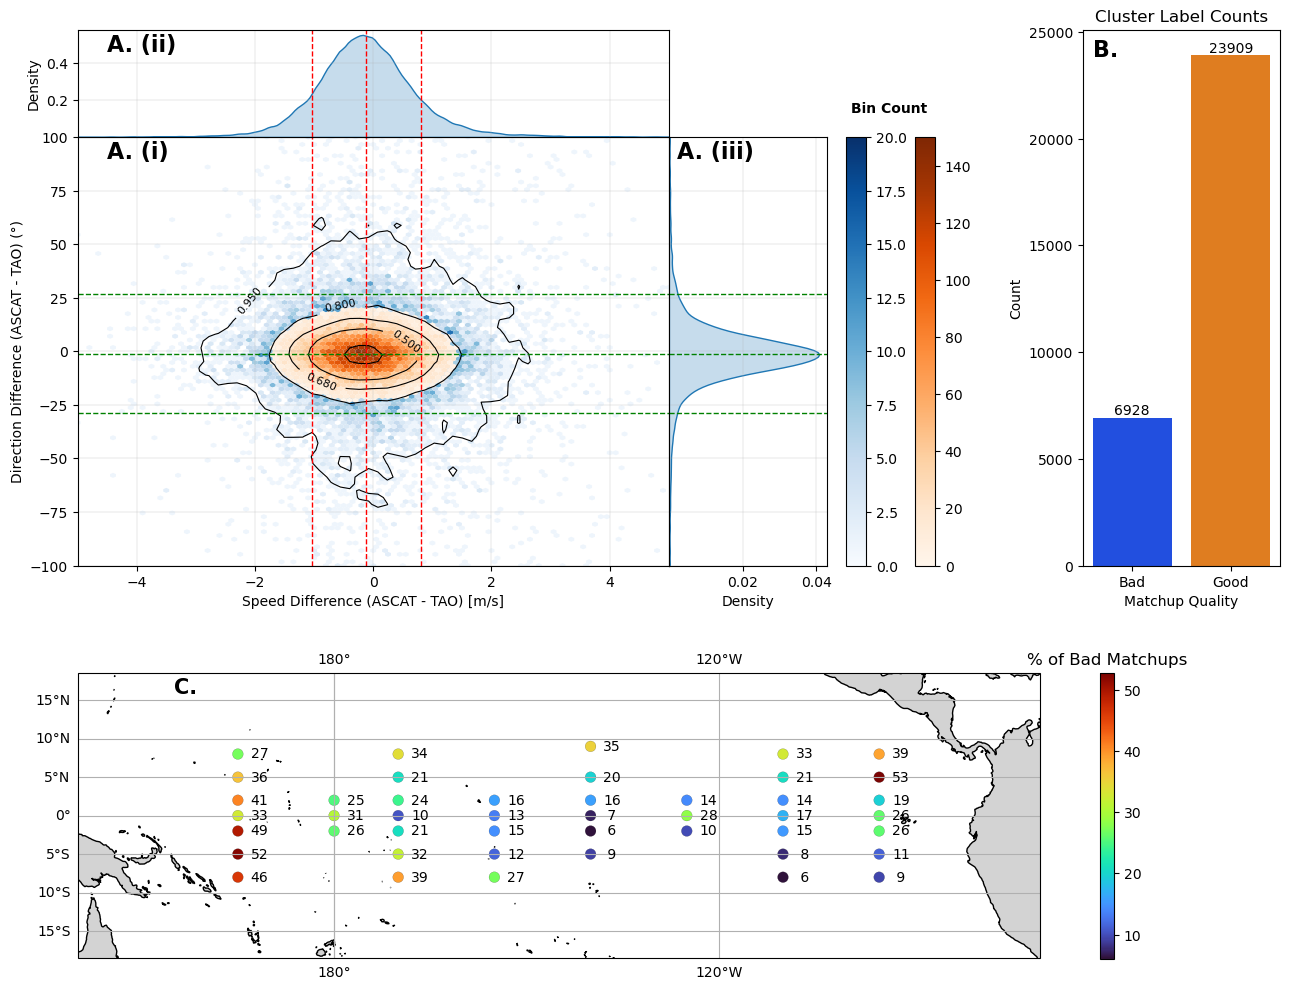

In [18]:
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.gridspec as gridspec
import pandas as pd

# Example DataFrame: df must contain 'label', 'speed', 'direction'
# Replace these with your actual column names
xlabel = 'Speed Difference (ASCAT - TAO)'
ylabel = 'Direction Difference (ASCAT - TAO)'

# Compute mean and std
mu_speed = df[xlabel].mean()
std_speed = df[xlabel].std()
mu_dir = df[ylabel].mean()
std_dir = df[ylabel].std()

# Create overall figure
fig = plt.figure(figsize=(13, 10))
gs = gridspec.GridSpec(4, 8, width_ratios=[3, 0.8, 0.1, 0.1, 0.25, 0.1, 0.75, 1], height_ratios=[0.75, 3, 0.75, 2], wspace=0, hspace=0)

# Joint and marginals (LEFT)
ax_joint = fig.add_subplot(gs[1, 0])
ax_marg_x = fig.add_subplot(gs[0, 0], sharex=ax_joint)
ax_marg_y = fig.add_subplot(gs[1, 1], sharey=ax_joint)
ax_cb1 = fig.add_subplot(gs[1,3])
ax_cb2 = fig.add_subplot(gs[1,5])

# Countplot (RIGHT)
ax_count = fig.add_subplot(gs[0:2, -1])  # spans both rows

# -------------------------
# 1. JOINT HISTOGRAM + KDE

colors = [plt.cm.Blues, plt.cm.Oranges]
hexcounts = [100, 100]
x_min, x_max, y_min, y_max = -5, 5, -100, 100
vmins = [0, 0]
vmaxs = [20, 150]
numcontours = 5

for i, (label, ax, ax_cb) in enumerate(zip([-1, 0], [ax_joint, ax_joint], [ax_cb1, ax_cb2])):
    df_label = df[df['label'] == label]

    hb = ax.hexbin(
        x=df_label[xlabel],
        y=df_label[ylabel],
        gridsize=hexcounts[i],
        cmap=colors[i],
        mincnt=1,
        linewidths=0.01,
        edgecolors=(0, 0, 0, 0.01),
        vmin=vmins[i],            # ← custom lower limit
        vmax=vmaxs[i],             # ← custom upper limit
        extent=(x_min, x_max, y_min, y_max)
    )

    # Extract colorbar for this label
    cbar = fig.colorbar(hb, cax=ax_cb)
    
#cbar.set_label("Bin Count")
cbar.ax.text(
    0.6, 1.05,                        # x=50% of width, y=just above the top
    "Bin Count",                     # your label
    ha='right', va='bottom',        # horizontal center, baseline aligned
    fontsize=10, fontweight='bold',  # optional styling
    transform=cbar.ax.transAxes      # relative to colorbar axis
)

# Create the Joint PDF plot and capture the returned QuadContourSet object
# KDE Grid resolution
nx, ny = 64, 64

# Data
x = df[xlabel].values
y = df[ylabel].values
xy = np.vstack([x, y])

# KDE with specified bandwidth
kde = gaussian_kde(xy, bw_method=0.1)

# Grid over which to evaluate
xx, yy = np.mgrid[x_min:x_max:nx*1j, y_min:y_max:ny*1j]
grid_coords = np.vstack([xx.ravel(), yy.ravel()])
z = kde(grid_coords).reshape(xx.shape)

# Normalize z to make it a probability surface (area ≈ 1)
dx = (x_max - x_min) / nx
dy = (y_max - y_min) / ny
z_prob = z / z.sum() #/ (dx * dy)

# Flatten and sort to get cumulative distribution
z_flat = z_prob.flatten()
z_sorted = np.sort(z_flat)[::-1]  # 🔄 descending order
z_cumsum = np.cumsum(z_sorted)

# Desired probability masses for contours
mass_levels = [0.1, 0.5, 0.68, 0.8, 0.95]
mass_levels.reverse()
levels = [z_sorted[np.searchsorted(z_cumsum, mass)] for mass in mass_levels]


#levels.sort()
# Plot contours
contour = ax_joint.contour(xx, yy, z_prob, levels=levels, colors='black', linewidths=0.8)

# Label with probability instead of density
fmt = {}
for l, s in zip(contour.levels, mass_levels):
    fmt[l] = f"{s:.3f}"  # show enclosed probability

#fmt = {level: f"{mass:.3f}" for level, mass in zip(levels, mass_levels)}

ax_joint.clabel(contour, contour.levels, inline=True, fmt=fmt, fontsize=8)
# # Add labels to the contour lines
# ax_joint.clabel(contour, inline=True, fontsize=8, fmt="%.2f")

# 2. MARGINAL KDEs
sns.kdeplot(data=df, x=xlabel, fill=True, legend=False, ax=ax_marg_x, clip = (x_min, x_max) , cut = 0, bw_adjust=0.5 )
sns.kdeplot(data=df, y=ylabel, fill=True, legend=False, ax=ax_marg_y, clip = (y_min, y_max) , cut = 0, bw_adjust=0.5 )

# Remove marginal axis ticks
ax_marg_x.tick_params(bottom=False, labelbottom=False)
ax_marg_y.tick_params(left=False, labelleft=False)

# Add ±1σ lines
for x in [mu_speed - std_speed, mu_speed, mu_speed + std_speed]:
    ax_joint.axvline(x, color='red', linestyle='--', linewidth=1)
    ax_marg_x.axvline(x, color='red', linestyle='--', linewidth=1)  
    ax_marg_x.set_yticks([0.2,0.4])

for y in [mu_dir - std_dir, mu_dir, mu_dir + std_dir]:
    ax_joint.axhline(y, color='green', linestyle='--', linewidth=1)
    ax_marg_y.axhline(y, color='green', linestyle='--', linewidth=1)
    ax_marg_y.set_xticks([0.02,0.04])


# Axis labels
ax_joint.set_xlabel(xlabel + ' [m/s]')
ax_joint.set_ylabel(ylabel + " (°)")
ax_marg_x.tick_params(axis='x', which='both', bottom=False, labelbottom=False)
ax_marg_y.tick_params(axis='y', which='both', left=False, labelleft=False)
ax_marg_x.set_xlabel(None)
ax_marg_y.set_ylabel(None)

# Label the panel
ax_joint.text(0.05, 0.95, 'A. (i)', transform=ax_joint.transAxes, fontsize=16, weight='bold')
ax_marg_x.text(0.05, 0.80, 'A. (ii)', transform=ax_marg_x.transAxes, fontsize=16, weight='bold')
ax_marg_y.text(0.05, 0.95, 'A. (iii)', transform=ax_marg_y.transAxes, fontsize=16, weight='bold')

# -------------------------
# 3. COUNTPLOT
s = sns.countplot(data=df, x='label', palette='bright', ax=ax_count)
s.bar_label(s.containers[0])
ax_count.set_title("Cluster Label Counts")
#ax_count.set_xticks([-1, 0])                    # positions (the actual cluster labels)
ax_count.set_xticklabels(["Bad", "Good"])       # the new labels shown on the axis
ax_count.set_xlabel("Matchup Quality")
ax_count.set_ylabel("Count")
ax_count.text(0.05, 0.95, 'B.', transform=ax_count.transAxes, fontsize=16, weight='bold')

# Final adjustments

ax_joint.set_xlim(x_min, x_max)
ax_joint.set_ylim(y_min,  y_max)
ax_joint.grid(lw = 0.2)

ax_marg_x.set_xlim(x_min, x_max)
ax_marg_x.grid(lw = 0.2)

ax_marg_y.set_ylim(y_min,  y_max)
ax_marg_y.grid(lw = 0.2)

######################################################################################################################

import cartopy.crs as ccrs
import cartopy.feature as cfeature 
dotSize = 60
slw = 0.1

latList = [-9, -8, -5, -2, 0, 2, 5, 8, 9]
lonList = [-95, -110, -125, -140, -155, -170, -180, 165]

ylen = len(latList)
xlen = len(lonList)

taskList = []

for latId  in range(ylen):
    for lonId in range(xlen):
        taskList.append([latList[latId], lonList[lonId]])

ntasks = len(taskList)

ax = fig.add_subplot(gs[3,:], projection=ccrs.PlateCarree(central_longitude=180))
ax.set_aspect(1.2)

land = cfeature.NaturalEarthFeature(
    category='physical',
    name='land',
    scale='50m',
    facecolor='lightgrey'  # Set the color to grey
)

ax.add_feature(land)


ax.set_extent([140, -70, -5, 5]) 
gridlines = ax.gridlines(draw_labels=True)
ax.coastlines()
plotList = np.zeros((0,3), dtype=float)
for task in taskList:
    lat = task[0]
    lon = task[1]
    txt = getGoodBad(lat, lon, df)
    

    xpos = lon + 180
    
    if xpos > 180:
       xpos -= 360
    if txt != '': 
        badPercent = getBadPercent(lat, lon, df)
        #print(badPercent)
        txt = f'{badPercent:2.0f}'
        ax.text(xpos+2, lat-0.5, txt)
        plotList = np.concatenate((plotList, np.array([[xpos, lat, badPercent]])), axis = 0)

x = ax.scatter(plotList[:,0], plotList[:,1], c=plotList[:,2], s=dotSize, edgecolor='black', linewidths=slw, cmap=cm.turbo)    
cb = plt.colorbar(x, ax = ax)
cb.ax.set_title('% of Bad Matchups')
#ax.scatter(df['LONGITUDE'], df['LATITUDE'], transform=ccrs.PlateCarree())

ax.text(0.1, 0.95, 'C. ', horizontalalignment='left',
        verticalalignment='center', transform=ax.transAxes,
        weight = 'heavy', fontsize = 15)


plt.tight_layout()

#plt.savefig('clustering.pdf', dpi=100)


In [ ]:
fig,  axes = plt.subplots(ncols = 2, figsize=(16,6))

ax = axes[0]

subDF = df.loc[df['label'].isin([0])]
s = sns.histplot(subDF, x=xlabel, y = ylabel,
                hue='label',  ax = ax, cbar = True,
                palette = sns.color_palette("bright"))

ax = axes[1]

subDF = df.loc[df['label'].isin([-1])]
s = sns.histplot(subDF, x=xlabel, y = ylabel,
                hue='label',  ax = ax, cbar = True,
                palette = sns.color_palette("bright"))


In [ ]:
goodBad = np.array(['good' for i in range(len(df))])
print(len(goodBad))
mask = df['label'].isin([-1])
goodBad[mask] = 'bad'
df['GoodBad'] = goodBad

In [ ]:
def getGoodBad(lat, lon, df):
    isPresent = False
    lon = (lon + 360)%360
    subDF = df.loc[df['LATITUDE'] == lat]
    subDF = subDF.loc[subDF['LONGITUDE'] == lon]
    if len(subDF) > 0:
        isPresent = True
    if isPresent:    
        goodCount = len(subDF.loc[subDF['GoodBad'] == 'good'])/len(subDF)*100
        badCount = len(subDF.loc[subDF['GoodBad'] == 'bad'])/len(subDF)*100
        return f' {goodCount:3.0f},{badCount:3.0f}'
    else:
        return ''

def getBadPercent(lat, lon, df):
    isPresent = False
    lon = (lon + 360)%360
    subDF = df.loc[df['LATITUDE'] == lat]
    subDF = subDF.loc[subDF['LONGITUDE'] == lon]
    if len(subDF) > 0:
        isPresent = True
    
    if isPresent:
        goodCount = len(subDF.loc[subDF['GoodBad'] == 'good'])/len(subDF)*100
        badCount = len(subDF.loc[subDF['GoodBad'] == 'bad'])/len(subDF)*100
        
        return badCount
    else:
        return -999

def getCount(lat, lon, df):
    isPresent = False
    lon = (lon + 360)%360
    subDF = df.loc[df['LATITUDE'] == lat]
    subDF = subDF.loc[subDF['LONGITUDE'] == lon]
    if len(subDF) > 0:
        isPresent = True
    if isPresent:
        count = len(subDF) #.loc[subDF['GoodBad'] == 'good'])/len(subDF)*100
        return count
    else:
        return -999


def getSpeedCorrelation(lat, lon, df, timeWindow=10):
    isPresent = False
    lon = (lon + 360)%360
    subDF = df.loc[df['LATITUDE'] == lat]
    subDF = subDF.loc[subDF['LONGITUDE'] == lon]
    if len(subDF) > 0:
        isPresent = True
    if isPresent:
        if timeWindow == 10:
            TAOlabel = 'Neutral Wind Speed at 10m (TAO)'
        else:
            TAOlabel = f'mean WSPD_10N {timeWindow}min'
        ASspeed = subDF['Wind Speed (ASCAT)'].to_numpy()
        TAOspeed = subDF[TAOlabel].to_numpy()
        corr = np.corrcoef(ASspeed, TAOspeed)[0,1]
        return corr
    else:
        return -999

def getDirCorrelation(lat, lon, df, timeWindow=10):
    isPresent = False
    lon = (lon + 360)%360
    subDF = df.loc[df['LATITUDE'] == lat]
    subDF = subDF.loc[subDF['LONGITUDE'] == lon]
    if len(subDF) > 0:
        isPresent = True
    if isPresent:
        if timeWindow == 10:
            TAOlabel = 'Wind Direction (TAO)'
        else:
            TAOlabel = f'mean WDIR {timeWindow}min'
        ASdir = subDF['Wind Direction (ASCAT)'].to_numpy()
        TAOdir = subDF[TAOlabel].to_numpy()
        corr = np.corrcoef(ASdir, TAOdir)[0,1]
        return corr
    else:
        return -999

def getXSpeedCorrelation(lat, lon, df, timeWindow=10):
    isPresent = False
    lon = (lon + 360)%360
    subDF = df.loc[df['LATITUDE'] == lat]
    subDF = subDF.loc[subDF['LONGITUDE'] == lon]
    if len(subDF) > 0:
        isPresent = True
    if isPresent:
        if timeWindow == 10:
            TAOlabel = 'Zonal Wind Speed (TAO)'
        else:
            TAOlabel = f'mean Ux_10N {timeWindow}min'
        ASspeed_x = subDF['Zonal Wind Speed (ASCAT)']
        TAOspeed_x = subDF[TAOlabel]
        corr = np.corrcoef(ASspeed_x, TAOspeed_x)[0,1]
        return corr
    else:
        return -999

def getYSpeedCorrelation(lat, lon, df, timeWindow=10):
    isPresent = False
    lon = (lon + 360)%360
    subDF = df.loc[df['LATITUDE'] == lat]
    subDF = subDF.loc[subDF['LONGITUDE'] == lon]
    if len(subDF) > 0:
        isPresent = True
        if timeWindow == 10:
            TAOlabel = 'Meridional Wind Speed (TAO)'
        else:
            TAOlabel = f'mean Vy_10N {timeWindow}min'
    if isPresent:
        ASspeed_y = subDF['Meridional Wind Speed (ASCAT)']
        TAOspeed_y = subDF[TAOlabel]
        corr = np.corrcoef(ASspeed_y, TAOspeed_y)[0,1]
        return corr
    else:
        return -999



    

In [ ]:
latList = [-9, -8, -5, -2, 0, 2, 5, 8, 9]
lonList = [-95, -110, -125, -140, -155, -170, -180, 165]

ylen = len(latList)
xlen = len(lonList)

taskList = []

for latId  in range(ylen):
    for lonId in range(xlen):
        taskList.append([latList[latId], lonList[lonId]])

ntasks = len(taskList)

import cartopy.crs as ccrs
import cartopy.feature as cfeature 
fig, axes = plt.subplots(nrows = 3, 
                       ncols = 1, 
                        figsize = (20,12),
                       subplot_kw={'projection': ccrs.PlateCarree(central_longitude=180)}, # "aspect": 1.2}, #1.2},
                       gridspec_kw = {'wspace':0.2, 'hspace':0.5}) 

land = cfeature.NaturalEarthFeature(
    category='physical',
    name='land',
    scale='50m',
    facecolor='lightgrey'  # Set the color to grey
)

ax = axes[0] 

ax.add_feature(land)


ax.set_extent([140, -70, -5, 5]) 
gridlines = ax.gridlines(draw_labels=True)
ax.coastlines()
for task in taskList:
    lat = task[0]
    lon = task[1]
    txt = getGoodBad(lat, lon, df)
    

    xpos = lon + 180
    
    if xpos > 180:
       xpos -= 360
    if txt != '': 
        badPercent = getBadPercent(lat, lon, df)
        #print(badPercent)
        ax.text(xpos, lat-0.5, txt)
        x = ax.scatter(xpos, lat, c=badPercent, vmin=0, vmax=50, s=60, cmap=cm.turbo)
    
cb = plt.colorbar(x, ax = ax)
cb.ax.set_title('% of Bad Matchups')
#ax.scatter(df['LONGITUDE'], df['LATITUDE'], transform=ccrs.PlateCarree())

ax.text(0.1, 0.95, 'A.  Percentage of Bad Matchups', horizontalalignment='left',
        verticalalignment='center', transform=ax.transAxes,
        weight = 'heavy', fontsize = 15)

###################################################################################################################
ax = axes[1]

ax.add_feature(land)

ax.set_extent([140, -70, -5, 5]) 
gridlines = ax.gridlines(draw_labels=True)
ax.coastlines()
for task in taskList:
    lat = task[0]
    lon = task[1]
    txt = getGoodBad(lat, lon, df)
    

    xpos = lon + 180
    
    if xpos > 180:
       xpos -= 360
    corr = getSpeedCorrelation(lat, lon, df)
    if corr != -999: 
        ax.text(xpos+1, lat-0.5, f'{corr:4.2f}')
        x = ax.scatter(xpos, lat, c=corr, vmin=0.5, vmax=0.95, s=60, cmap=cm.turbo)
    
cb = plt.colorbar(x, ax = ax)
cb.ax.set_title('Corr. Coeff.')

ax.text(0.1, 0.95, 'B.  Wind Speed Correlation', horizontalalignment='left',
        verticalalignment='center', transform=ax.transAxes,
        weight = 'heavy', fontsize = 15)


###################################################################################################################
ax = axes[2]

ax.add_feature(land)

ax.set_extent([140, -70, -5, 5]) 
gridlines = ax.gridlines(draw_labels=True)
ax.coastlines()
for task in taskList:
    lat = task[0]
    lon = task[1]
    txt = getGoodBad(lat, lon, df)
    

    xpos = lon + 180
    
    if xpos > 180:
       xpos -= 360
    corr = getDirCorrelation(lat, lon, df)
    #print(corr)
    if corr != -999: 
        ax.text(xpos+1, lat-0.5, f'{corr:4.2f}')
        x = ax.scatter(xpos, lat, c=corr, vmin=0.40, vmax=0.85, s=60, cmap=cm.turbo)
    
cb = plt.colorbar(x, ax = ax)
cb.ax.set_title('Corr. Coeff.')
#ax.scatter(df['LONGITUDE'], df['LATITUDE'], transform=ccrs.PlateCarree())

ax.text(0.1, 0.95, 'C.  Wind Direction Correlation', horizontalalignment='left',
        verticalalignment='center', transform=ax.transAxes,
        weight = 'heavy', fontsize = 15)

plt.subplots_adjust(left = 0.01, right = 1, top =0.98 , bottom = 0.02, wspace=0 , hspace=0)
#plt.tight_layout()

#plt.savefig('goodVsBad.png', dpi=100)


In [ ]:
fig, axes = plt.subplots(nrows=2 , ncols=2, figsize=(20,8))

subDF = df.loc[df['GoodBad'] == 'good']
ax = axes[0,0]
xlabel = 'Neutral Wind Speed at 10m (TAO)'
ylabel = 'Wind Speed (ASCAT)'
sns.histplot(subDF, x = xlabel, y = ylabel, ax = ax)


ax = axes[0,1]
xlabel = 'Wind Direction (TAO)'
ylabel = 'Wind Direction (ASCAT)'
sns.histplot(subDF, x = xlabel, y = ylabel, ax = ax)


subDF = df.loc[df['GoodBad'] == 'bad']
ax = axes[1,0]
xlabel = 'Neutral Wind Speed at 10m (TAO)'
ylabel = 'Wind Speed (ASCAT)'
sns.histplot(subDF, x = xlabel, y = ylabel, ax = ax)


ax = axes[1,1]
xlabel = 'Wind Direction (TAO)'
ylabel = 'Wind Direction (ASCAT)'
sns.histplot(subDF, x = xlabel, y = ylabel, ax = ax)


In [ ]:
fig, axes = plt.subplots(nrows=2 , ncols=2, figsize=(20,8))

subDF = df.loc[df['GoodBad'] == 'good']
ax = axes[0,0]
xlabel = 'Zonal Neutral Wind Speed (TAO)'
ylabel = 'Zonal Wind Speed (ASCAT)'
sns.histplot(subDF, x = xlabel, y = ylabel, ax = ax)


ax = axes[0,1]
xlabel = 'Meridional Neutral Wind Speed (TAO)'
ylabel = 'Meridional Wind Speed (ASCAT)'
sns.histplot(subDF, x = xlabel, y = ylabel, ax = ax)


subDF = df.loc[df['GoodBad'] == 'bad']
ax = axes[1,0]
xlabel = 'Zonal Neutral Wind Speed (TAO)'
ylabel = 'Zonal Wind Speed (ASCAT)'
sns.histplot(subDF, x = xlabel, y = ylabel, ax = ax)


ax = axes[1,1]
xlabel = 'Meridional Neutral Wind Speed (TAO)'
ylabel = 'Meridional Wind Speed (ASCAT)'
sns.histplot(subDF, x = xlabel, y = ylabel, ax = ax)


In [ ]:
fig, axes = plt.subplots(nrows = 4, 
                       ncols = 1, 
                        figsize = (20,20),
                       subplot_kw={'projection': ccrs.PlateCarree(central_longitude=180)}, # "aspect": 1.2}, #1.2},
                       gridspec_kw = {'wspace':0.2, 'hspace':0.5}) 

land = cfeature.NaturalEarthFeature(
    category='physical',
    name='land',
    scale='50m',
    facecolor='lightgrey'  # Set the color to grey
)


subDF = df.loc[df['GoodBad'] =='good']
ax = axes[0] 
ax.add_feature(land)

ax.set_extent([140, -70, -5, 5]) 
gridlines = ax.gridlines(draw_labels=True)
ax.coastlines()
for task in taskList:
    lat = task[0]
    lon = task[1]
    xpos = lon + 180
    
    if xpos > 180:
       xpos -= 360
    corr = getSpeedCorrelation(lat, lon, subDF)
    if corr != -999: 
        ax.text(xpos+1, lat-0.5, f'{corr:4.2f}')
        x = ax.scatter(xpos, lat, c=corr, vmin=0, vmax=1, s=60, cmap=cm.turbo)
    
cb = plt.colorbar(x, ax = ax)
cb.ax.set_title('Corr. Coeff.')

ax.text(0.1, 0.95, 'A.  Wind Speed Correlation for Good Matchups', horizontalalignment='left',
        verticalalignment='center', transform=ax.transAxes,
        weight = 'heavy', fontsize = 15)



###################################################################################################################

ax = axes[1]
ax.add_feature(land)

ax.set_extent([140, -70, -5, 5]) 
gridlines = ax.gridlines(draw_labels=True)
ax.coastlines()
for task in taskList:
    lat = task[0]
    lon = task[1]
    txt = getGoodBad(lat, lon, df)
    

    xpos = lon + 180
    
    if xpos > 180:
       xpos -= 360
    corr = getDirCorrelation(lat, lon, subDF)
    #print(corr)
    if corr != -999: 
        ax.text(xpos+1, lat-0.5, f'{corr:4.2f}')
        x = ax.scatter(xpos, lat, c=corr, vmin=0, vmax=1, s=60, cmap=cm.turbo)
    
cb = plt.colorbar(x, ax = ax)
cb.ax.set_title('Corr. Coeff.')

ax.text(0.1, 0.95, 'B.  Wind Direction Correlation for Good Matchups', horizontalalignment='left',
        verticalalignment='center', transform=ax.transAxes,
        weight = 'heavy', fontsize = 15)

###################################################################################################################
subDF = df.loc[df['GoodBad'] =='bad']
ax = axes[2] 
ax.add_feature(land)

ax.set_extent([140, -70, -5, 5]) 
gridlines = ax.gridlines(draw_labels=True)
ax.coastlines()
for task in taskList:
    lat = task[0]
    lon = task[1]
    xpos = lon + 180
    
    if xpos > 180:
       xpos -= 360
    corr = getSpeedCorrelation(lat, lon, subDF)
    if corr != -999: 
        ax.text(xpos+1, lat-0.5, f'{corr:4.2f}')
        x = ax.scatter(xpos, lat, c=corr, vmin=0, vmax=1, s=60, cmap=cm.turbo)
    
cb = plt.colorbar(x, ax = ax)
cb.ax.set_title('Corr. Coeff.')

ax.text(0.1, 0.95, 'C.  Wind Speed Correlation for Bad Matchups', horizontalalignment='left',
        verticalalignment='center', transform=ax.transAxes,
        weight = 'heavy', fontsize = 15)



###################################################################################################################
ax = axes[3]
ax.add_feature(land)

ax.set_extent([140, -70, -5, 5]) 
gridlines = ax.gridlines(draw_labels=True)
ax.coastlines()
for task in taskList:
    lat = task[0]
    lon = task[1]
    txt = getGoodBad(lat, lon, df)
    

    xpos = lon + 180
    
    if xpos > 180:
       xpos -= 360
    corr = getDirCorrelation(lat, lon, subDF)
    #print(corr)
    if corr != -999: 
        ax.text(xpos+1, lat-0.5, f'{corr:4.2f}')
        x = ax.scatter(xpos, lat, c=corr, vmin=0, vmax=1, s=60, cmap=cm.turbo)
    
cb = plt.colorbar(x, ax = ax)
cb.ax.set_title('Corr. Coeff.')

ax.text(0.1, 0.95, 'D.  Wind Direction Correlation for Bad Matchups', horizontalalignment='left',
        verticalalignment='center', transform=ax.transAxes,
        weight = 'heavy', fontsize = 15)

###################################################################################################################

In [ ]:
fig, axes = plt.subplots(nrows=4, ncols =4, sharex = False, figsize=(15,16))
histkind = "stack"
cmap = plt.get_cmap('coolwarm').copy()
cmap.set_bad('white')
custom_bins_RH = np.linspace(65,100,50)
custom_bins_SST = np.linspace(20,32,50)
custom_bins_AIRT = np.linspace(15,32,50)
custom_bins_U10x = np.linspace(-15,10,50)
ny = 10
stack_order = {'good', 'bad'}

xlabel = 'Relative Humidity (TAO)'
title = 'For Buoy locations lat > 3 N'
ax = axes[0,0]
subDF = df.loc[df['LATITUDE'] > 3]
subDF = subDF.rename(columns = {'GoodBad':'Matchup Agreement'})
# goodDF = subDF.loc[subDF['GoodBad'] == 'good']
# badDF = subDF.loc[subDF['GoodBad'] == 'bad']

sns.kdeplot(subDF.iloc[::-1], x=xlabel, 
             #bins= custom_bins_RH, 
             hue='Matchup Agreement', 
             #multiple=histkind,
             palette = {'good': 'green', 'bad': 'red'}, 
             #hue_order=stack_order,
             common_norm = False, 
             ax = ax)

#ax.set_title(title)
#ax.set_xlabel('TAO Relative Humidity')
ax.grid(visible=True, which='major')

ax = axes[0,1]
xlabel = 'Sea Surface Temperature (TAO)'
custom_bins_SST = np.linspace(25,31,50)

sns.kdeplot(subDF.iloc[::-1], x=xlabel, 
             #bins= custom_bins_RH, 
             hue='Matchup Agreement', 
             #multiple=histkind,
             palette = {'good': 'green', 'bad': 'red'}, 
             #hue_order=stack_order,
             common_norm = False, 
             ax = ax)
#ax.set_title(title)
#ax.set_xlabel('TAO Sea Surface Temperature')
ax.grid(visible=True, which='major')


ax = axes[0,2]
xlabel = 'Air Temperature (TAO)'
custom_bins_AIRT = np.linspace(23,30,50)

sns.kdeplot(subDF.iloc[::-1], x=xlabel, 
             #bins= custom_bins_RH, 
             hue='Matchup Agreement', 
             #multiple=histkind,
             palette = {'good': 'green', 'bad': 'red'}, 
             #hue_order=stack_order,
             common_norm = False, 
             ax = ax)
#ax.set_title(title)
#ax.set_xlabel('TAO Air Temperature')
ax.grid(visible=True, which='major')

xlabel = 'Zonal Neutral Wind Speed (TAO)'
ax = axes[0,3]

sns.kdeplot(subDF.iloc[::-1], x=xlabel, 
             #bins= custom_bins_RH, 
             hue='Matchup Agreement', 
             #multiple=histkind,
             palette = {'good': 'green', 'bad': 'red'}, 
             #hue_order=stack_order,
             common_norm = False, 
             ax = ax)
#ax.set_title(title)
#ax.set_xlabel('TAO Zonal winds')
ax.grid(visible=True, which='major')

################################################################################################

xlabel = 'Relative Humidity (TAO)'
title = 'For Buoy locations lon < -165 E '
ax = axes[1,0]
subDF = df.loc[df['LONGITUDE'] < (360-165)]
subDF = subDF.rename(columns = {'GoodBad':'Matchup Agreement'})
# goodDF = subDF.loc[subDF['GoodBad'] == 'good']
# badDF = subDF.loc[subDF['GoodBad'] == 'bad']

sns.kdeplot(subDF.iloc[::-1], x=xlabel, 
             #bins= custom_bins_RH, 
             hue='Matchup Agreement', 
             #multiple=histkind,
             palette = {'good': 'green', 'bad': 'red'}, 
             #hue_order=stack_order,
             common_norm = False, 
             ax = ax)
#ax.set_title(title)
#x.set_xlabel('TAO Relative Humidity')
ax.grid(visible=True, which='major')

ax = axes[1,1]
xlabel = 'Sea Surface Temperature (TAO)'
custom_bins_SST = np.linspace(26,32,50)

sns.kdeplot(subDF.iloc[::-1], x=xlabel, 
             #bins= custom_bins_RH, 
             hue='Matchup Agreement', 
             #multiple=histkind,
             palette = {'good': 'green', 'bad': 'red'}, 
             #hue_order=stack_order,
             common_norm = False, 
             ax = ax)
#ax.set_title(title)
#ax.set_xlabel('TAO Sea Surface Temperature')
ax.grid(visible=True, which='major')

ax = axes[1,2]
xlabel = 'Air Temperature (TAO)'
custom_bins_AIRT = np.linspace(24,30.5,50)

sns.kdeplot(subDF.iloc[::-1], x=xlabel, 
             #bins= custom_bins_RH, 
             hue='Matchup Agreement', 
             #multiple=histkind,
             palette = {'good': 'green', 'bad': 'red'}, 
             #hue_order=stack_order,
             common_norm = False, 
             ax = ax)
#ax.set_title(title)
#ax.set_xlabel('TAO Air Temperature')
ax.grid(visible=True, which='major')

xlabel = 'Zonal Neutral Wind Speed (TAO)'
ax = axes[1,3]

sns.kdeplot(subDF.iloc[::-1], x=xlabel, 
             #bins= custom_bins_RH, 
             hue='Matchup Agreement', 
             #multiple=histkind,
             palette = {'good': 'green', 'bad': 'red'}, 
             #hue_order=stack_order,
             common_norm = False, 
             ax = ax)
#ax.set_title(title)
#ax.set_xlabel('TAO Zonal winds')
ax.grid(visible=True, which='major')


################################################################################################
xlabel = 'Relative Humidity (TAO)'
title = 'For Buoy locations lon > -120 E '

ax = axes[2,0]
subDF = df.loc[df['LONGITUDE'] > (360-120)]
subDF = subDF.rename(columns = {'GoodBad':'Matchup Agreement'})
# goodDF = subDF.loc[subDF['GoodBad'] == 'good']
# badDF = subDF.loc[subDF['GoodBad'] == 'bad']

sns.kdeplot(subDF.iloc[::-1], x=xlabel, 
             #bins= custom_bins_RH, 
             hue='Matchup Agreement', 
             #multiple=histkind,
             palette = {'good': 'green', 'bad': 'red'}, 
             #hue_order=stack_order,
             common_norm = False, 
             ax = ax)
#ax.set_title(title)
#ax.set_xlabel('TAO Relative Humidity')
ax.grid(visible=True, which='major')
#ax.text(-0.01, 0.33, 'Eastern Pacific', transform=ax.transAxes, rotation=90)

ax = axes[2,1]
xlabel = 'Sea Surface Temperature (TAO)'
custom_bins_SST = np.linspace(20,30,50)

sns.kdeplot(subDF.iloc[::-1], x=xlabel, 
             #bins= custom_bins_RH, 
             hue='Matchup Agreement', 
             #multiple=histkind,
             palette = {'good': 'green', 'bad': 'red'}, 
             #hue_order=stack_order,
             common_norm = False, 
             ax = ax)
#ax.set_title(title)
#ax.set_xlabel('TAO Sea Surface Temperature')
ax.grid(visible=True, which='major')

ax = axes[2,2]
xlabel = 'Air Temperature (TAO)'
custom_bins_AIRT = np.linspace(20,29,50)

sns.kdeplot(subDF.iloc[::-1], x=xlabel, 
             #bins= custom_bins_RH, 
             hue='Matchup Agreement', 
             #multiple=histkind,
             palette = {'good': 'green', 'bad': 'red'}, 
             #hue_order=stack_order,
             common_norm = False, 
             ax = ax)
#ax.set_title(title)
#ax.set_xlabel('TAO Air Temperature')
ax.grid(visible=True, which='major')

xlabel = 'Zonal Neutral Wind Speed (TAO)'
ax = axes[2,3]

sns.kdeplot(subDF.iloc[::-1], x=xlabel, 
             #bins= custom_bins_RH, 
             hue='Matchup Agreement', 
             #multiple=histkind,
             palette = {'good': 'green', 'bad': 'red'}, 
             #hue_order=stack_order,
             common_norm = False, 
             ax = ax)
#ax.set_title(title)
#ax.set_xlabel('TAO Zonal winds')
ax.grid(visible=True, which='major')


################################################################################################
################################################################################################

xlabel = 'Relative Humidity (TAO)'
title = 'For Buoy locations lon < -165 E '
ax = axes[3,0]
subDF = df.copy()
subDF = subDF.rename(columns = {'GoodBad':'Matchup Agreement'})
# goodDF = subDF.loc[subDF['GoodBad'] == 'good']
# badDF = subDF.loc[subDF['GoodBad'] == 'bad']

sns.kdeplot(subDF.iloc[::-1], x=xlabel, 
             #bins= custom_bins_RH, 
             hue='Matchup Agreement', 
             #multiple=histkind,
             palette = {'good': 'green', 'bad': 'red'}, 
             #hue_order=stack_order,
             common_norm = False, 
             ax = ax)
#ax.set_title(title)
#x.set_xlabel('TAO Relative Humidity')
ax.grid(visible=True, which='major')

ax = axes[3,1]
xlabel = 'Sea Surface Temperature (TAO)'
custom_bins_SST = np.linspace(26,32,50)

sns.kdeplot(subDF.iloc[::-1], x=xlabel, 
             #bins= custom_bins_RH, 
             hue='Matchup Agreement', 
             #multiple=histkind,
             palette = {'good': 'green', 'bad': 'red'}, 
             #hue_order=stack_order,
             common_norm = False, 
             ax = ax)
#ax.set_title(title)
#ax.set_xlabel('TAO Sea Surface Temperature')
ax.grid(visible=True, which='major')

ax = axes[3,2]
xlabel = 'Air Temperature (TAO)'
custom_bins_AIRT = np.linspace(24,30.5,50)

sns.kdeplot(subDF.iloc[::-1], x=xlabel, 
             #bins= custom_bins_RH, 
             hue='Matchup Agreement', 
             #multiple=histkind,
             palette = {'good': 'green', 'bad': 'red'}, 
             #hue_order=stack_order,
             common_norm = False, 
             ax = ax)
#ax.set_title(title)
#ax.set_xlabel('TAO Air Temperature')
ax.grid(visible=True, which='major')

xlabel = 'Zonal Neutral Wind Speed (TAO)'
ax = axes[3,3]

sns.kdeplot(subDF.iloc[::-1], x=xlabel, 
             #bins= custom_bins_RH, 
             hue='Matchup Agreement', 
             #multiple=histkind,
             palette = {'good': 'green', 'bad': 'red'}, 
             #hue_order=stack_order,
             common_norm = False, 
             ax = ax)
#ax.set_title(title)
#ax.set_xlabel('TAO Zonal winds')
ax.grid(visible=True, which='major')

plt.subplots_adjust(left=0.05, bottom=0.05, right=0.98, top=0.9, wspace=0.25, hspace=0.25)
#plt.savefig('StackedHistogram.png', dpi = 100)

In [ ]:
fig, axes = plt.subplots(nrows=6, ncols =1, sharex = True, figsize=(20,15))

cmap = plt.get_cmap('coolwarm').copy()
cmap.set_bad('white')
nx = 12*7*5 # 168
ny = 10

title = 'For Buoy locations lat > 3 N'
ax = axes[0]
subDF = df.loc[df['LATITUDE'] > 3]
goodDF = subDF.loc[subDF['GoodBad'] == 'good']
badDF = subDF.loc[subDF['GoodBad'] == 'bad']

stack_order = ['good','bad']
sns.histplot(subDF, x='AS_TIME', bins= nx, hue='GoodBad',  multiple="stack", 
             palette = {'good': 'green', 'bad': 'red'}, 
             hue_order=stack_order, 
             ax = ax)
sns.move_legend(ax, "upper left")
ax.set_title(title, weight='heavy')


ax = axes[1]
GoodCounts, bin_edges, _ = ax.hist(goodDF['AS_TIME'], bins=nx, color='blue', alpha=0)  # Use 
BadCounts, bin_edges, _ = ax.hist(badDF['AS_TIME'], bins=nx, color='Red', alpha=0)  # Use 
BadPercent = BadCounts/(GoodCounts+BadCounts) * 100
ax.plot(bin_edges[0:-1], BadPercent)
ax.set_ylim(0,100)
ax.set_ylabel('Bad Data %')
################################################################################################

title = 'For Buoy locations lon < -165 E '
ax = axes[2]
subDF = df.loc[df['LONGITUDE'] < (360-165)]
goodDF = subDF.loc[subDF['GoodBad'] == 'good']
badDF = subDF.loc[subDF['GoodBad'] == 'bad']

sns.histplot(subDF, x='AS_TIME', bins= nx, hue='GoodBad',  multiple="stack", 
             hue_order=stack_order, 
             palette = {'good': 'green', 'bad': 'red'}, ax = ax)
sns.move_legend(ax, "upper left")
ax.set_title(title, weight='heavy')

ax = axes[3]
GoodCounts, bin_edges, _ = ax.hist(goodDF['AS_TIME'], bins=nx, color='blue', alpha=0)  # Use 
BadCounts, bin_edges, _ = ax.hist(badDF['AS_TIME'], bins=nx, color='Red', alpha=0)  # Use 
BadPercent = BadCounts/(GoodCounts+BadCounts) * 100
ax.plot(bin_edges[0:-1], BadPercent)
ax.set_ylim(0,100)
ax.set_ylabel('Bad Data %')
################################################################################################

title = 'For Buoy locations lon > -120 E '
ax = axes[4]
subDF = df.loc[df['LONGITUDE'] > (360-120)]
goodDF = subDF.loc[subDF['GoodBad'] == 'good']
badDF = subDF.loc[subDF['GoodBad'] == 'bad']

sns.histplot(subDF, x='AS_TIME', bins= nx, hue='GoodBad', multiple="stack",  
             hue_order=stack_order, 
             palette = {'good': 'green', 'bad': 'red'}, ax = ax)
sns.move_legend(ax, "upper left")
ax.set_title(title, weight='heavy')

ax = axes[5]
GoodCounts, bin_edges, _ = ax.hist(goodDF['AS_TIME'], bins=nx, color='blue', alpha=0)  # Use 
BadCounts, bin_edges, _ = ax.hist(badDF['AS_TIME'], bins=nx, color='Red', alpha=0)  # Use 
BadPercent = BadCounts/(GoodCounts+BadCounts) * 100
ax.plot(bin_edges[0:-1], BadPercent)
ax.set_ylim(0,100)
ax.set_ylabel('Bad Data %')
################################################################################################

In [ ]:
df['day'] = np.array([var.timetuple().tm_yday for var in df['AS_TIME']])

In [ ]:
fig, axes = plt.subplots(nrows=8, ncols =1, sharex = True, figsize=(20,15))

cmap = plt.get_cmap('coolwarm').copy()
cmap.set_bad('white')
nx = 365 #int(365//3)
ny = 10
nrun = 30

title = 'For Buoy locations lat > 3 N'
ax = axes[0]
subDF = df.loc[df['LATITUDE'] > 3]
goodDF = subDF.loc[subDF['GoodBad'] == 'good']
badDF = subDF.loc[subDF['GoodBad'] == 'bad']

stack_order = ['good','bad']
sns.histplot(subDF, x='day', bins= nx, hue='GoodBad',  multiple="stack", 
             palette = {'good': 'green', 'bad': 'red'}, 
             hue_order=stack_order, 
             ax = ax)
sns.move_legend(ax, "upper left")
ax.set_title(title, weight='heavy')


ax = axes[1]
GoodCounts, bin_edges, _ = ax.hist(goodDF['day'], bins=nx, color='blue', alpha=0)  # Use 
BadCounts, bin_edges, _ = ax.hist(badDF['day'], bins=nx, color='Red', alpha=0)  # Use 
BadPercent = BadCounts/(GoodCounts+BadCounts) * 100
ax.plot(bin_edges[0:-1], BadPercent, label ='badPercent')
ax.plot(bin_edges[0:-1], convolve1d(BadPercent, np.ones(nrun)/nrun, mode='wrap'), label =f'badPercent {nrun} day running avg')
ax.legend()
ax.set_ylim(18,45)
ax.set_ylabel('Bad Data %')
################################################################################################

title = 'For Buoy locations lon < -165 E '
ax = axes[2]
subDF = df.loc[df['LONGITUDE'] < (360-165)]
goodDF = subDF.loc[subDF['GoodBad'] == 'good']
badDF = subDF.loc[subDF['GoodBad'] == 'bad']

sns.histplot(subDF, x='day', bins= nx, hue='GoodBad',  multiple="stack", 
             hue_order=stack_order, 
             palette = {'good': 'green', 'bad': 'red'}, ax = ax)
sns.move_legend(ax, "upper left")
ax.set_title(title, weight='heavy')

ax = axes[3]
GoodCounts, bin_edges, _ = ax.hist(goodDF['day'], bins=nx, color='blue', alpha=0)  # Use 
BadCounts, bin_edges, _ = ax.hist(badDF['day'], bins=nx, color='Red', alpha=0)  # Use 
BadPercent = BadCounts/(GoodCounts+BadCounts) * 100
ax.plot(bin_edges[0:-1], BadPercent, label ='badPercent')
ax.plot(bin_edges[0:-1], convolve1d(BadPercent, np.ones(nrun)/nrun, mode='wrap'), label =f'badPercent {nrun} day running avg')
ax.legend()
ax.set_ylim(20,50)
ax.set_ylabel('Bad Data %')
################################################################################################

title = 'For Buoy locations lon > -120 E '
ax = axes[4]
subDF = df.loc[df['LONGITUDE'] > (360-120)]
goodDF = subDF.loc[subDF['GoodBad'] == 'good']
badDF = subDF.loc[subDF['GoodBad'] == 'bad']

sns.histplot(subDF, x='day', bins= nx, hue='GoodBad', multiple="stack",  
             hue_order=stack_order, 
             palette = {'good': 'green', 'bad': 'red'}, ax = ax)
sns.move_legend(ax, "upper left")
ax.set_title(title, weight='heavy')

ax = axes[5]
GoodCounts, bin_edges, _ = ax.hist(goodDF['day'], bins=nx, color='blue', alpha=0)  # Use 
BadCounts, bin_edges, _ = ax.hist(badDF['day'], bins=nx, color='Red', alpha=0)  # Use 
BadPercent = BadCounts/(GoodCounts+BadCounts) * 100
ax.plot(bin_edges[0:-1], BadPercent, label ='badPercent')
ax.plot(bin_edges[0:-1], convolve1d(BadPercent, np.ones(nrun)/nrun, mode='wrap'), label =f'badPercent {nrun} day running avg')
ax.set_ylim(10,40)
ax.legend()
ax.set_ylabel('Bad Data %')
################################################################################################
################################################################################################

title = 'For All Locations'
ax = axes[6]
subDF = df.copy()
goodDF = subDF.loc[subDF['GoodBad'] == 'good']
badDF = subDF.loc[subDF['GoodBad'] == 'bad']

sns.histplot(subDF, x='day', bins= nx, hue='GoodBad', multiple="stack",  
             hue_order=stack_order, 
             palette = {'good': 'green', 'bad': 'red'}, ax = ax)
sns.move_legend(ax, "upper left")
ax.set_title(title, weight='heavy')

ax = axes[7]
GoodCounts, bin_edges, _ = ax.hist(goodDF['day'], bins=nx, color='blue', alpha=0)  # Use 
BadCounts, bin_edges, _ = ax.hist(badDF['day'], bins=nx, color='Red', alpha=0)  # Use 
BadPercent = BadCounts/(GoodCounts+BadCounts) * 100
ax.plot(bin_edges[0:-1], BadPercent, label ='badPercent')
ax.plot(bin_edges[0:-1], convolve1d(BadPercent, np.ones(nrun)/nrun, mode='wrap'), label =f'badPercent {nrun} day running avg')
ax.set_ylim(10,40)
ax.legend()
ax.set_ylabel('Bad Data %')
ax.set_xlabel('Day of year')
ax.set_xlabel('Day of year')

In [ ]:
fig, axes = plt.subplots(nrows=4, ncols =4, sharex = False, figsize=(15,16))
histkind = "stack"
cmap = plt.get_cmap('coolwarm').copy()
cmap.set_bad('white')
custom_bins_RH = np.linspace(65,100,50)
custom_bins_SST = np.linspace(20,32,50)
custom_bins_AIRT = np.linspace(15,32,50)
custom_bins_U10x = np.linspace(-15,10,50)
ny = 10
stack_order = ['good', 'bad']

xlabel = 'Relative Humidity (TAO)'
title = 'For Buoy locations lat > 3 N'
ax = axes[0,0]
subDF = df.loc[df['LATITUDE'] > 3]
subDF = subDF.rename(columns = {'GoodBad':'Matchup Agreement'})
# goodDF = subDF.loc[subDF['GoodBad'] == 'good']
# badDF = subDF.loc[subDF['GoodBad'] == 'bad']

sns.histplot(subDF, x=xlabel, 
             hue='Matchup Agreement', 
             multiple="stack", 
             palette = {'good': 'green', 'bad': 'red'}, 
             hue_order=stack_order, 
             ax = ax)

#ax.set_title(title)
#ax.set_xlabel('TAO Relative Humidity')
ax.grid(visible=True, which='major')

ax = axes[0,1]
xlabel = 'Sea Surface Temperature (TAO)'
custom_bins_SST = np.linspace(25,31,50)

sns.histplot(subDF.iloc[::-1], x=xlabel, 
             #bins= custom_bins_RH, 
             hue='Matchup Agreement', 
             multiple='stack',
             palette = {'good': 'green', 'bad': 'red'}, 
             hue_order=stack_order,
             common_norm = False, 
             ax = ax)
#ax.set_title(title)
#ax.set_xlabel('TAO Sea Surface Temperature')
ax.grid(visible=True, which='major')


ax = axes[0,2]
xlabel = 'Air Temperature (TAO)'
custom_bins_AIRT = np.linspace(23,30,50)

sns.histplot(subDF.iloc[::-1], x=xlabel, 
             #bins= custom_bins_RH, 
             hue='Matchup Agreement', 
             multiple='stack',
             palette = {'good': 'green', 'bad': 'red'}, 
             hue_order=stack_order,
             common_norm = False, 
             ax = ax)
#ax.set_title(title)
#ax.set_xlabel('TAO Air Temperature')
ax.grid(visible=True, which='major')

xlabel = 'Zonal Neutral Wind Speed (TAO)'
ax = axes[0,3]

sns.histplot(subDF.iloc[::-1], x=xlabel, 
             #bins= custom_bins_RH, 
             hue='Matchup Agreement', 
             multiple='stack',
             palette = {'good': 'green', 'bad': 'red'}, 
             hue_order=stack_order,
             common_norm = False, 
             ax = ax)
#ax.set_title(title)
#ax.set_xlabel('TAO Zonal winds')
ax.grid(visible=True, which='major')

################################################################################################

xlabel = 'Relative Humidity (TAO)'
title = 'For Buoy locations lon < -165 E '
ax = axes[1,0]
subDF = df.loc[df['LONGITUDE'] < (360-165)]
subDF = subDF.rename(columns = {'GoodBad':'Matchup Agreement'})
# goodDF = subDF.loc[subDF['GoodBad'] == 'good']
# badDF = subDF.loc[subDF['GoodBad'] == 'bad']

sns.histplot(subDF.iloc[::-1], x=xlabel, 
             #bins= custom_bins_RH, 
             hue='Matchup Agreement', 
             multiple='stack',
             palette = {'good': 'green', 'bad': 'red'}, 
             hue_order=stack_order,
             common_norm = False, 
             ax = ax)
#ax.set_title(title)
#x.set_xlabel('TAO Relative Humidity')
ax.grid(visible=True, which='major')

ax = axes[1,1]
xlabel = 'Sea Surface Temperature (TAO)'
custom_bins_SST = np.linspace(26,32,50)

sns.histplot(subDF.iloc[::-1], x=xlabel, 
             #bins= custom_bins_RH, 
             hue='Matchup Agreement', 
             multiple='stack',
             palette = {'good': 'green', 'bad': 'red'}, 
             hue_order=stack_order,
             common_norm = False, 
             ax = ax)
#ax.set_title(title)
#ax.set_xlabel('TAO Sea Surface Temperature')
ax.grid(visible=True, which='major')

ax = axes[1,2]
xlabel = 'Air Temperature (TAO)'
custom_bins_AIRT = np.linspace(24,30.5,50)

sns.histplot(subDF.iloc[::-1], x=xlabel, 
             #bins= custom_bins_RH, 
             hue='Matchup Agreement', 
             multiple='stack',
             palette = {'good': 'green', 'bad': 'red'}, 
             hue_order=stack_order,
             common_norm = False, 
             ax = ax)
#ax.set_title(title)
#ax.set_xlabel('TAO Air Temperature')
ax.grid(visible=True, which='major')

xlabel = 'Zonal Neutral Wind Speed (TAO)'
ax = axes[1,3]

sns.histplot(subDF.iloc[::-1], x=xlabel, 
             #bins= custom_bins_RH, 
             hue='Matchup Agreement', 
             multiple='stack',
             palette = {'good': 'green', 'bad': 'red'}, 
             hue_order=stack_order,
             common_norm = False, 
             ax = ax)
#ax.set_title(title)
#ax.set_xlabel('TAO Zonal winds')
ax.grid(visible=True, which='major')


################################################################################################
xlabel = 'Relative Humidity (TAO)'
title = 'For Buoy locations lon > -120 E '

ax = axes[2,0]
subDF = df.loc[df['LONGITUDE'] > (360-120)]
subDF = subDF.rename(columns = {'GoodBad':'Matchup Agreement'})
# goodDF = subDF.loc[subDF['GoodBad'] == 'good']
# badDF = subDF.loc[subDF['GoodBad'] == 'bad']

sns.histplot(subDF.iloc[::-1], x=xlabel, 
             #bins= custom_bins_RH, 
             hue='Matchup Agreement', 
             multiple='stack',
             palette = {'good': 'green', 'bad': 'red'}, 
             hue_order=stack_order,
             common_norm = False, 
             ax = ax)
#ax.set_title(title)
#ax.set_xlabel('TAO Relative Humidity')
ax.grid(visible=True, which='major')
#ax.text(-0.01, 0.33, 'Eastern Pacific', transform=ax.transAxes, rotation=90)

ax = axes[2,1]
xlabel = 'Sea Surface Temperature (TAO)'
custom_bins_SST = np.linspace(20,30,50)

sns.histplot(subDF.iloc[::-1], x=xlabel, 
             #bins= custom_bins_RH, 
             hue='Matchup Agreement', 
             multiple='stack',
             palette = {'good': 'green', 'bad': 'red'}, 
             hue_order=stack_order,
             common_norm = False, 
             ax = ax)
#ax.set_title(title)
#ax.set_xlabel('TAO Sea Surface Temperature')
ax.grid(visible=True, which='major')

ax = axes[2,2]
xlabel = 'Air Temperature (TAO)'
custom_bins_AIRT = np.linspace(20,29,50)

sns.histplot(subDF.iloc[::-1], x=xlabel, 
             #bins= custom_bins_RH, 
             hue='Matchup Agreement', 
             multiple='stack',
             palette = {'good': 'green', 'bad': 'red'}, 
             hue_order=stack_order,
             common_norm = False, 
             ax = ax)
#ax.set_title(title)
#ax.set_xlabel('TAO Air Temperature')
ax.grid(visible=True, which='major')

xlabel = 'Zonal Neutral Wind Speed (TAO)'
ax = axes[2,3]

sns.histplot(subDF.iloc[::-1], x=xlabel, 
             #bins= custom_bins_RH, 
             hue='Matchup Agreement', 
             multiple='stack',
             palette = {'good': 'green', 'bad': 'red'}, 
             hue_order=stack_order,
             common_norm = False, 
             ax = ax)
#ax.set_title(title)
#ax.set_xlabel('TAO Zonal winds')
ax.grid(visible=True, which='major')


################################################################################################
################################################################################################

xlabel = 'Relative Humidity (TAO)'
title = 'For Buoy locations lon < -165 E '
ax = axes[3,0]
subDF = df.copy()
subDF = subDF.rename(columns = {'GoodBad':'Matchup Agreement'})
# goodDF = subDF.loc[subDF['GoodBad'] == 'good']
# badDF = subDF.loc[subDF['GoodBad'] == 'bad']

sns.histplot(subDF.iloc[::-1], x=xlabel, 
             #bins= custom_bins_RH, 
             hue='Matchup Agreement', 
             multiple='stack',
             palette = {'good': 'green', 'bad': 'red'}, 
             hue_order=stack_order,
             common_norm = False, 
             ax = ax)
#ax.set_title(title)
#x.set_xlabel('TAO Relative Humidity')
ax.grid(visible=True, which='major')

ax = axes[3,1]
xlabel = 'Sea Surface Temperature (TAO)'
custom_bins_SST = np.linspace(26,32,50)

sns.histplot(subDF.iloc[::-1], x=xlabel, 
             #bins= custom_bins_RH, 
             hue='Matchup Agreement', 
             multiple='stack',
             palette = {'good': 'green', 'bad': 'red'}, 
             hue_order=stack_order,
             common_norm = False, 
             ax = ax)
#ax.set_title(title)
#ax.set_xlabel('TAO Sea Surface Temperature')
ax.grid(visible=True, which='major')

ax = axes[3,2]
xlabel = 'Air Temperature (TAO)'
custom_bins_AIRT = np.linspace(24,30.5,50)

sns.histplot(subDF.iloc[::-1], x=xlabel, 
             #bins= custom_bins_RH, 
             hue='Matchup Agreement', 
             multiple='stack',
             palette = {'good': 'green', 'bad': 'red'}, 
             hue_order=stack_order,
             common_norm = False, 
             ax = ax)
#ax.set_title(title)
#ax.set_xlabel('TAO Air Temperature')
ax.grid(visible=True, which='major')

xlabel = 'Zonal Neutral Wind Speed (TAO)'
ax = axes[3,3]

sns.histplot(subDF.iloc[::-1], x=xlabel, 
             #bins= custom_bins_RH, 
             hue='Matchup Agreement', 
             multiple='stack',
             palette = {'good': 'green', 'bad': 'red'}, 
             hue_order=stack_order,
             common_norm = False, 
             ax = ax)
#ax.set_title(title)
#ax.set_xlabel('TAO Zonal winds')
ax.grid(visible=True, which='major')

plt.subplots_adjust(left=0.05, bottom=0.05, right=0.98, top=0.9, wspace=0.25, hspace=0.25)
#plt.savefig('StackedHistogram.png', dpi = 100)

In [ ]:
fig, axes = plt.subplots(nrows=4, ncols =4, sharex = False, figsize=(15,16))
histkind = "stack"
cmap = plt.get_cmap('coolwarm').copy()
cmap.set_bad('white')
custom_bins_RH = np.linspace(65,100,50)
custom_bins_SST = np.linspace(20,32,50)
custom_bins_AIRT = np.linspace(15,32,50)
custom_bins_U10x = np.linspace(-15,10,50)
ny = 10
stack_order = {'good', 'bad'}

xlabel = 'Relative Humidity (TAO)'
title = 'For Buoy locations lat > 3 N'
ax = axes[0,0]
subDF = df.loc[df['LATITUDE'] > 3]
subDF = subDF.loc[subDF['Neutral Wind Speed at 10m (TAO)'] > 4]
subDF = subDF.rename(columns = {'GoodBad':'Matchup Agreement'})
# goodDF = subDF.loc[subDF['GoodBad'] == 'good']
# badDF = subDF.loc[subDF['GoodBad'] == 'bad']

sns.kdeplot(subDF.iloc[::-1], x=xlabel, 
             #bins= custom_bins_RH, 
             hue='Matchup Agreement', 
             #multiple=histkind,
             palette = {'good': 'green', 'bad': 'red'}, 
             #hue_order=stack_order,
             common_norm = False, 
             ax = ax)

#ax.set_title(title)
#ax.set_xlabel('TAO Relative Humidity')
ax.grid(visible=True, which='major')

ax = axes[0,1]
xlabel = 'Sea Surface Temperature (TAO)'
custom_bins_SST = np.linspace(25,31,50)

sns.kdeplot(subDF.iloc[::-1], x=xlabel, 
             #bins= custom_bins_RH, 
             hue='Matchup Agreement', 
             #multiple=histkind,
             palette = {'good': 'green', 'bad': 'red'}, 
             #hue_order=stack_order,
             common_norm = False, 
             ax = ax)
#ax.set_title(title)
#ax.set_xlabel('TAO Sea Surface Temperature')
ax.grid(visible=True, which='major')


ax = axes[0,2]
xlabel = 'Air Temperature (TAO)'
custom_bins_AIRT = np.linspace(23,30,50)

sns.kdeplot(subDF.iloc[::-1], x=xlabel, 
             #bins= custom_bins_RH, 
             hue='Matchup Agreement', 
             #multiple=histkind,
             palette = {'good': 'green', 'bad': 'red'}, 
             #hue_order=stack_order,
             common_norm = False, 
             ax = ax)
#ax.set_title(title)
#ax.set_xlabel('TAO Air Temperature')
ax.grid(visible=True, which='major')

xlabel = 'Zonal Neutral Wind Speed (TAO)'
ax = axes[0,3]

sns.kdeplot(subDF.iloc[::-1], x=xlabel, 
             #bins= custom_bins_RH, 
             hue='Matchup Agreement', 
             #multiple=histkind,
             palette = {'good': 'green', 'bad': 'red'}, 
             #hue_order=stack_order,
             common_norm = False, 
             ax = ax)
#ax.set_title(title)
#ax.set_xlabel('TAO Zonal winds')
ax.grid(visible=True, which='major')

################################################################################################

xlabel = 'Relative Humidity (TAO)'
title = 'For Buoy locations lon < -165 E '
ax = axes[1,0]
subDF = df.loc[df['LONGITUDE'] < (360-165)]
subDF = subDF.loc[subDF['Neutral Wind Speed at 10m (TAO)'] > 4]
subDF = subDF.rename(columns = {'GoodBad':'Matchup Agreement'})
# goodDF = subDF.loc[subDF['GoodBad'] == 'good']
# badDF = subDF.loc[subDF['GoodBad'] == 'bad']

sns.kdeplot(subDF.iloc[::-1], x=xlabel, 
             #bins= custom_bins_RH, 
             hue='Matchup Agreement', 
             #multiple=histkind,
             palette = {'good': 'green', 'bad': 'red'}, 
             #hue_order=stack_order,
             common_norm = False, 
             ax = ax)
#ax.set_title(title)
#x.set_xlabel('TAO Relative Humidity')
ax.grid(visible=True, which='major')

ax = axes[1,1]
xlabel = 'Sea Surface Temperature (TAO)'
custom_bins_SST = np.linspace(26,32,50)

sns.kdeplot(subDF.iloc[::-1], x=xlabel, 
             #bins= custom_bins_RH, 
             hue='Matchup Agreement', 
             #multiple=histkind,
             palette = {'good': 'green', 'bad': 'red'}, 
             #hue_order=stack_order,
             common_norm = False, 
             ax = ax)
#ax.set_title(title)
#ax.set_xlabel('TAO Sea Surface Temperature')
ax.grid(visible=True, which='major')

ax = axes[1,2]
xlabel = 'Air Temperature (TAO)'
custom_bins_AIRT = np.linspace(24,30.5,50)

sns.kdeplot(subDF.iloc[::-1], x=xlabel, 
             #bins= custom_bins_RH, 
             hue='Matchup Agreement', 
             #multiple=histkind,
             palette = {'good': 'green', 'bad': 'red'}, 
             #hue_order=stack_order,
             common_norm = False, 
             ax = ax)
#ax.set_title(title)
#ax.set_xlabel('TAO Air Temperature')
ax.grid(visible=True, which='major')

xlabel = 'Zonal Neutral Wind Speed (TAO)'
ax = axes[1,3]

sns.kdeplot(subDF.iloc[::-1], x=xlabel, 
             #bins= custom_bins_RH, 
             hue='Matchup Agreement', 
             #multiple=histkind,
             palette = {'good': 'green', 'bad': 'red'}, 
             #hue_order=stack_order,
             common_norm = False, 
             ax = ax)
#ax.set_title(title)
#ax.set_xlabel('TAO Zonal winds')
ax.grid(visible=True, which='major')


################################################################################################
xlabel = 'Relative Humidity (TAO)'
title = 'For Buoy locations lon > -120 E '

ax = axes[2,0]
subDF = df.loc[df['LONGITUDE'] > (360-120)]
subDF = subDF.loc[subDF['Neutral Wind Speed at 10m (TAO)'] > 4]
subDF = subDF.rename(columns = {'GoodBad':'Matchup Agreement'})
# goodDF = subDF.loc[subDF['GoodBad'] == 'good']
# badDF = subDF.loc[subDF['GoodBad'] == 'bad']

sns.kdeplot(subDF.iloc[::-1], x=xlabel, 
             #bins= custom_bins_RH, 
             hue='Matchup Agreement', 
             #multiple=histkind,
             palette = {'good': 'green', 'bad': 'red'}, 
             #hue_order=stack_order,
             common_norm = False, 
             ax = ax)
#ax.set_title(title)
#ax.set_xlabel('TAO Relative Humidity')
ax.grid(visible=True, which='major')
#ax.text(-0.01, 0.33, 'Eastern Pacific', transform=ax.transAxes, rotation=90)

ax = axes[2,1]
xlabel = 'Sea Surface Temperature (TAO)'
custom_bins_SST = np.linspace(20,30,50)

sns.kdeplot(subDF.iloc[::-1], x=xlabel, 
             #bins= custom_bins_RH, 
             hue='Matchup Agreement', 
             #multiple=histkind,
             palette = {'good': 'green', 'bad': 'red'}, 
             #hue_order=stack_order,
             common_norm = False, 
             ax = ax)
#ax.set_title(title)
#ax.set_xlabel('TAO Sea Surface Temperature')
ax.grid(visible=True, which='major')

ax = axes[2,2]
xlabel = 'Air Temperature (TAO)'
custom_bins_AIRT = np.linspace(20,29,50)

sns.kdeplot(subDF.iloc[::-1], x=xlabel, 
             #bins= custom_bins_RH, 
             hue='Matchup Agreement', 
             #multiple=histkind,
             palette = {'good': 'green', 'bad': 'red'}, 
             #hue_order=stack_order,
             common_norm = False, 
             ax = ax)
#ax.set_title(title)
#ax.set_xlabel('TAO Air Temperature')
ax.grid(visible=True, which='major')

xlabel = 'Zonal Neutral Wind Speed (TAO)'
ax = axes[2,3]

sns.kdeplot(subDF.iloc[::-1], x=xlabel, 
             #bins= custom_bins_RH, 
             hue='Matchup Agreement', 
             #multiple=histkind,
             palette = {'good': 'green', 'bad': 'red'}, 
             #hue_order=stack_order,
             common_norm = False, 
             ax = ax)
#ax.set_title(title)
#ax.set_xlabel('TAO Zonal winds')
ax.grid(visible=True, which='major')


################################################################################################
################################################################################################

xlabel = 'Relative Humidity (TAO)'
title = 'For Buoy locations lon < -165 E '
ax = axes[3,0]
subDF = df.copy()
subDF = subDF.loc[subDF['Neutral Wind Speed at 10m (TAO)'] > 4]
subDF = subDF.rename(columns = {'GoodBad':'Matchup Agreement'})
# goodDF = subDF.loc[subDF['GoodBad'] == 'good']
# badDF = subDF.loc[subDF['GoodBad'] == 'bad']

sns.kdeplot(subDF.iloc[::-1], x=xlabel, 
             #bins= custom_bins_RH, 
             hue='Matchup Agreement', 
             #multiple=histkind,
             palette = {'good': 'green', 'bad': 'red'}, 
             #hue_order=stack_order,
             common_norm = False, 
             ax = ax)
#ax.set_title(title)
#x.set_xlabel('TAO Relative Humidity')
ax.grid(visible=True, which='major')

ax = axes[3,1]
xlabel = 'Sea Surface Temperature (TAO)'
custom_bins_SST = np.linspace(26,32,50)

sns.kdeplot(subDF.iloc[::-1], x=xlabel, 
             #bins= custom_bins_RH, 
             hue='Matchup Agreement', 
             #multiple=histkind,
             palette = {'good': 'green', 'bad': 'red'}, 
             #hue_order=stack_order,
             common_norm = False, 
             ax = ax)
#ax.set_title(title)
#ax.set_xlabel('TAO Sea Surface Temperature')
ax.grid(visible=True, which='major')

ax = axes[3,2]
xlabel = 'Air Temperature (TAO)'
custom_bins_AIRT = np.linspace(24,30.5,50)

sns.kdeplot(subDF.iloc[::-1], x=xlabel, 
             #bins= custom_bins_RH, 
             hue='Matchup Agreement', 
             #multiple=histkind,
             palette = {'good': 'green', 'bad': 'red'}, 
             #hue_order=stack_order,
             common_norm = False, 
             ax = ax)
#ax.set_title(title)
#ax.set_xlabel('TAO Air Temperature')
ax.grid(visible=True, which='major')

xlabel = 'Zonal Neutral Wind Speed (TAO)'
ax = axes[3,3]

sns.kdeplot(subDF.iloc[::-1], x=xlabel, 
             #bins= custom_bins_RH, 
             hue='Matchup Agreement', 
             #multiple=histkind,
             palette = {'good': 'green', 'bad': 'red'}, 
             #hue_order=stack_order,
             common_norm = False, 
             ax = ax)
#ax.set_title(title)
#ax.set_xlabel('TAO Zonal winds')
ax.grid(visible=True, which='major')

plt.subplots_adjust(left=0.05, bottom=0.05, right=0.98, top=0.9, wspace=0.25, hspace=0.25)
#plt.savefig('StackedHistogram.png', dpi = 100)